# Autoencoder in DeepLearning

# Question 2

In [ ]:
# import libaraies
import torch
from torch import nn
import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from torchvision.transforms.transforms import InterpolationMode
from sklearn.manifold import TSNE

In [ ]:
!pip install -q torchmetrics
from torchmetrics.classification import MulticlassAccuracy

In [ ]:
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
# prepare augmentation
# Create training transform with RandomRotation and gaussion noise augmentation
train_transform_trivial_augment = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomRotation(10, interpolation = InterpolationMode.NEAREST, expand = False),
    transforms.GaussianBlur(kernel_size = 3, sigma = 0.01),
    transforms.ToTensor()
])

# Create training transform (no data augmentation)
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [ ]:
# get datasets
train_data = CIFAR10(root = 'data', train = True, transform = train_transform, download = True) 
train_data_aug = CIFAR10(root = 'data', train = True, transform = train_transform_trivial_augment, download = True)
test_data = CIFAR10(root = 'data', train = False, transform = test_transform, download = True)
# test_data_aug = CIFAR10(root = 'data', train = False, transform = train_transform_trivial_augment, download = True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Get only even class data

In [ ]:
train_list = []
train_aug_list = []
test_list = []


for i, (x,y) in enumerate(train_data):
  if y % 2 == 0:
    train_list.append(train_data[i])
  # print(train_data[i])
  # break
for i, (x,y) in enumerate(train_data_aug):
  if y % 2 == 0:
    train_aug_list.append(train_data_aug[i])

for x,y in test_data:
  if y % 2 == 0:
    test_list.append((x, y))

len(train_list), len(train_aug_list), len(test_list)

(25000, 25000, 5000)

In [ ]:
# concate datasets
new_train_data = torch.utils.data.ConcatDataset((train_list, train_aug_list))
new_test_data = torch.utils.data.ConcatDataset([test_list])

In [ ]:
len(new_train_data), len(new_test_data)

(50000, 5000)

In [ ]:
# fit dataset in Dataloader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = new_train_data, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)

print(f"total {len(train_dataloader)} train data loader of each {BATCH_SIZE} batch size")
print(f"total {len(test_dataloader)} test data loader of each {BATCH_SIZE} batch size")

total 1563 train data loader of each 32 batch size
total 313 test data loader of each 32 batch size


In [ ]:
# class name
class_names = [train_data.classes[i] for i in range(len(train_data.classes)) if i % 2 == 0] 
class_names

['airplane', 'bird', 'deer', 'frog', 'ship']

In [ ]:
# give index to class
class_idx = train_data.class_to_idx
class_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

## Visulize Data

image shape: torch.Size([1, 32, 32])


Text(0.5, 1.0, 'frog')

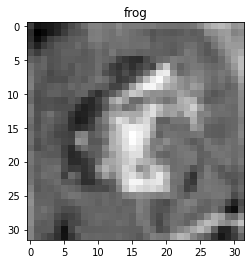

In [ ]:
image, label = train_data[0]
print(f"image shape: {image.shape}")
plt.imshow(image.T.squeeze(), cmap='gray')
plt.title(class_names[label//2])

In [ ]:
# look the size and shape of dataloader
train_feature_batch, train_label_batch = next(iter(train_dataloader))
train_feature_batch.shape, train_label_batch.shape

(torch.Size([32, 1, 32, 32]), torch.Size([32]))

Text(0.5, 1.0, 'airplane')

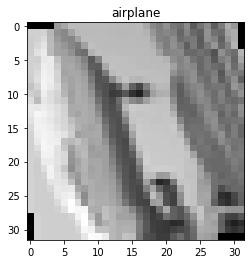

In [ ]:
# image from dataloader
torch.manual_seed(64)

random_idx = torch.randint(0, len(train_feature_batch), size = [1]).item()
image, label = train_feature_batch[random_idx], train_label_batch[random_idx]
plt.imshow(image.T.squeeze(), cmap = 'gray')
plt.title(class_names[label//2])

## Building an Auto encoder

In [ ]:
# Auto ancode model
class AutoEncoder(nn.Module):
  def __init__(self, input_units : int, output_units: int):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(in_features = input_units, out_features = output_units),
        nn.Sigmoid(),
        nn.Linear(in_features = output_units, out_features = output_units),
        nn.Sigmoid(),
        nn.Linear(in_features = output_units, out_features = output_units),
        # nn.Sigmoid(),
        # nn.Linear(in_features = output_units, out_features = output_units),
        # nn.Sigmoid()
    )

    self.decoder = nn.Sequential(
        # nn.Linear(in_features = output_units, out_features = output_units),
        # nn.Sigmoid(),
        nn.Linear(in_features = output_units, out_features = output_units),
        nn.Sigmoid(),
        nn.Linear(in_features = output_units, out_features = output_units),
        nn.Sigmoid(),
        nn.Linear(in_features = output_units, out_features = input_units),
        # nn.Sigmoid()
    )

  def encode(self, x):
    return self.encoder(x.view(-1, 1024))

  def decode(self, z):
    return self.decoder(z)

  def forward(self, x):
    z = self.encode(x)
    return self.decode(z)


##Xavier Initialization

In [ ]:
def weights_init(c_name):
    if isinstance(c_name, nn.Linear):
        torch.nn.init.xavier_uniform_(c_name.weight)
        torch.nn.init.zeros_(c_name.bias)

## Train and Test Step

In [ ]:
from tqdm.auto import tqdm

# train loop
def train_loop(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  
  # train
  train_loss = 0
  # train_loss_loop = []
  # train_loss_lst = []
  for batch, (train_data, _) in enumerate(dataloader):

    # add noice in image (gaussian noise)
    # data = train_data + 0.2*torch.randn_like(train_data)
    # print(x_train.shape)

    if device == 'cuda':
      # x_train, y_train = x_train.to(device), y_train.to(device)
      train_data = train_data.to(device)
      # data = data.to(device)

    model.train()

    # 1. Forward
    train_data = train_data.reshape(-1, 1024)
    pred = model(train_data)

    # 2. Loss and Accuracy
    loss = loss_fn(pred, train_data)
    train_loss += loss
    # train_loss_lst.append(loss.item())

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. Backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

  train_loss /= len(dataloader)
  # train_loss_loop.append(train_loss)
  

  # print(f"Train Loss: {train_loss:.4f}")
  return train_loss

# test loop
def test_loop(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  
  test_loss = 0
  # test_loss_loop = []
  # test_loss_lst = []
  # pass model for evaluation
  model.eval()
  with torch.inference_mode():
    for i, (test_data, _) in enumerate(dataloader):
      if device == 'cuda':
        # x_test, y_test = x_test.to(device), y_test.to(device)
        test_data = test_data.to(device)

      # 1. Forward
      test_data = test_data.reshape(-1, 1024)
      test_pred = model(test_data)

      # 2. Loss
      loss = loss_fn(test_pred, test_data)

      test_loss += loss

      # test_loss_lst.append(loss)

    test_loss /= len(dataloader)
    # test_loss_loop.append(test_loss)

  # print(f"Test Loss: {test_loss:.4f}")
  return test_loss


## loss and optimizer for encoder class

In [ ]:
torch.manual_seed(64)
torch.cuda.manual_seed(64)
auto_model = AutoEncoder(input_units = 1024, output_units = 512).to(device)
auto_model.apply(weights_init)
print(auto_model)

# loss
loss_fn = nn.MSELoss()
# loss_fn = nn.L1Loss()

# optimizer
optimizer = torch.optim.SGD(params = auto_model.parameters(), lr = 0.001)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=512, out_features=512, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=512, out_features=1024, bias=True)
  )
)


In [ ]:
# train model
epoches = 10

torch.manual_seed(42)
torch.cuda.manual_seed(42)


train = []
test = []
for epoch in tqdm(range(epoches)):

  train_loss = train_loop(model = auto_model, dataloader = train_dataloader,
                          loss_fn = loss_fn, optimizer = optimizer, device = device)
  
  test_loss = test_loop(model = auto_model, dataloader = test_dataloader,
                        loss_fn = loss_fn, device = device)
  
  print(f"Epoch: {epoch+1} Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")


  train.append(train_loss.item())
  test.append(test_loss.item())



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 0.3240 | Test Loss: 0.2315
Epoch: 2 Train Loss: 0.1713 | Test Loss: 0.1340
Epoch: 3 Train Loss: 0.1049 | Test Loss: 0.0907
Epoch: 4 Train Loss: 0.0756 | Test Loss: 0.0716
Epoch: 5 Train Loss: 0.0628 | Test Loss: 0.0634
Epoch: 6 Train Loss: 0.0573 | Test Loss: 0.0598
Epoch: 7 Train Loss: 0.0550 | Test Loss: 0.0583
Epoch: 8 Train Loss: 0.0541 | Test Loss: 0.0577
Epoch: 9 Train Loss: 0.0537 | Test Loss: 0.0574
Epoch: 10 Train Loss: 0.0535 | Test Loss: 0.0573


In [ ]:
## loss vs epoch plot
def loss_plot(train, test):
  plt.figure(figsize = (10,7))
  # plt.plot(range(1, epoches*(len(train_dataloader)*BATCH_SIZE) + 1), train)
  plt.plot(range(len(train)),train, label = "Train Loss")
  plt.plot(range(len(test)),test, label = "Test Loss")
  plt.xlabel("Epoches")
  plt.ylabel("Loss")
  plt.title("Loss")
  plt.legend()
  plt.show()

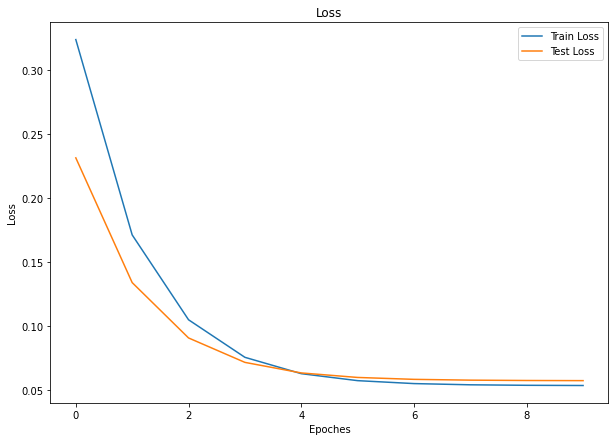

In [ ]:
loss_plot(train, test)

##FC1 Model

In [ ]:
# build base model (FC1)
class AutoCIFAR10(nn.Module):
  def __init__(self, input_units: int, output_units: int, hidden_units: int):
    super().__init__()
    # # self.encoder = 
    # self.encoder = nn.Sequential(
    #     nn.Linear(in_features = input_units, out_features = hidden_units),
    #     nn.Sigmoid(),
    #     nn.Linear(in_features = hidden_units, out_features = hidden_units),
    #     nn.Sigmoid(),
    #     nn.Linear(in_features = hidden_units, out_features = hidden_units),
    #     nn.Sigmoid(),
    #     nn.Linear(in_features = hidden_units, out_features = hidden_units),
    #     nn.Sigmoid()
    # )
    self.layer_stack = nn.Sequential(
        # nn.Flatten(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.Tanh(),
        nn.Linear(in_features = hidden_units, out_features = output_units),
        # nn.Tanh()
    )

    # self.decoder = nn.Sequential(
    #     nn.Linear(in_features = output_units, out_features = hidden_units),
    #     nn.Sigmoid(),
    #     nn.Linear(in_features = hidden_units, out_features = hidden_units),
    #     nn.Sigmoid(),
    #     nn.Linear(in_features = hidden_units, out_features = hidden_units),
    #     nn.Sigmoid(),
    #     nn.Linear(in_features = hidden_units, out_features = input_units),
    #     nn.Sigmoid()
    # )
    
  def forward(self, x):
    x = auto_model.encode(x)
    return self.layer_stack(x)

  # def decode(self, x):
  #   return self.decoder(x)

# torch.manual_seed(64)
# torch.cuda.manual_seed(64)
# fc1_model = FashionMNISTModelFC1(input_units = 784, output_units = len(class_name), hidden_units = 20)
# fc1_model

## train and test loop for FC

In [ ]:
# train
def train_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, 
               accuracy_fn, device: torch.device = device):
  
  train_loss, train_acc = 0, 0

  for batch, (x_train, y_train) in enumerate(dataloader):

    if device == 'cuda':
      x_train, y_train = x_train.to(device), y_train.to(device)

    model.train()
    y_train = y_train // 2
    # 1. Forward
    y_pred = model(x_train)

    # 2. Loss
    loss = loss_fn(y_pred, y_train)
    acc = accuracy_fn(y_train, torch.argmax(y_pred, dim = 1))
    train_loss += loss
    train_acc += acc

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. Backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc


def test_loop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module, accuracy_fn, device: torch.device = device):
  test_loss, test_acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for x_test, y_test in dataloader:
      if device == 'cuda':
        x_test, y_test = x_test.to(device), y_test.to(device)

      y_test = y_test // 2
      # 1. Forward
      test_pred = model(x_test)

      # 2. Loss
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_test, torch.argmax(test_pred, dim = 1))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc


## Loss and Accuracy plot vs Epoch

In [ ]:
def plotplot(train_losses, test_losses, train_acces, test_acces):
  plt.figure(figsize = (25,8))
  # plt.plot(range(1, epoches*(len(train_dataloader)*BATCH_SIZE) + 1), train)
  plt.subplot(1,2,1)
  plt.plot(range(len(train_losses)),train_losses, label = "Train Loss")
  plt.plot(range(len(test_losses)),test_losses, label = "Test Loss")
  plt.xlabel("Epoches")
  plt.ylabel("Loss")
  plt.title("Loss vs Epoches")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(range(len(train_acces)),train_acces, label = "Train Accuracy")
  plt.plot(range(len(test_acces)),test_acces, label = "Test Accuracy")
  plt.xlabel("Epoches")
  plt.ylabel("Accuracy")
  plt.title("Accuracy vs Epoches")
  plt.legend()

  plt.show()

In [ ]:
# train model

torch.manual_seed(64)
torch.cuda.manual_seed(64)
fc1_model = AutoCIFAR10(input_units = 1024, output_units = len(class_names), hidden_units = 512).to(device)
fc1_model.apply(weights_init)
print(fc1_model)

# loss and optimizer
# loss
loss_fn = nn.CrossEntropyLoss()

# optimizer
fc1_optimizer = torch.optim.SGD(params = fc1_model.parameters(), lr = 0.01)
# fc3_optimizer = torch.optim.SGD(params = fc3_model.parameters(), lr = 0.1)

# accuracy
accuracy_fn = MulticlassAccuracy(num_classes = len(class_names)).to(device)

epoches = 10

torch.manual_seed(64)
torch.cuda.manual_seed(64)

train_losses, test_losses = [], []
train_acces, test_acces = [], []

torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):

  train_loss, train_acc = train_loop(model = fc1_model, dataloader = train_dataloader,
                                     loss_fn = loss_fn, optimizer = fc1_optimizer,
                                     accuracy_fn = accuracy_fn, device = device)
  
  test_loss, test_acc = test_loop(model = fc1_model, dataloader = test_dataloader, 
                                  loss_fn = loss_fn, accuracy_fn = accuracy_fn, device = device)
  
  print(f"Epoch: {epoch+1} Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  train_acces.append(train_acc.item())
  test_acces.append(test_acc.item())


AutoCIFAR10(
  (layer_stack): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=5, bias=True)
  )
)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 Train Loss: 1.6183 | Train Acc: 0.08% | Test Loss: 1.6279 | Test Acc: 0.04%
Epoch: 2 Train Loss: 1.5917 | Train Acc: 0.14% | Test Loss: 1.5923 | Test Acc: 0.15%
Epoch: 3 Train Loss: 1.5660 | Train Acc: 0.18% | Test Loss: 1.5874 | Test Acc: 0.18%
Epoch: 4 Train Loss: 1.5498 | Train Acc: 0.22% | Test Loss: 1.5607 | Test Acc: 0.27%
Epoch: 5 Train Loss: 1.5344 | Train Acc: 0.25% | Test Loss: 1.6068 | Test Acc: 0.24%
Epoch: 6 Train Loss: 1.5280 | Train Acc: 0.27% | Test Loss: 1.5527 | Test Acc: 0.20%
Epoch: 7 Train Loss: 1.5196 | Train Acc: 0.29% | Test Loss: 1.6496 | Test Acc: 0.16%
Epoch: 8 Train Loss: 1.5116 | Train Acc: 0.29% | Test Loss: 1.5375 | Test Acc: 0.29%
Epoch: 9 Train Loss: 1.5082 | Train Acc: 0.30% | Test Loss: 1.6473 | Test Acc: 0.12%
Epoch: 10 Train Loss: 1.5022 | Train Acc: 0.31% | Test Loss: 1.6656 | Test Acc: 0.20%


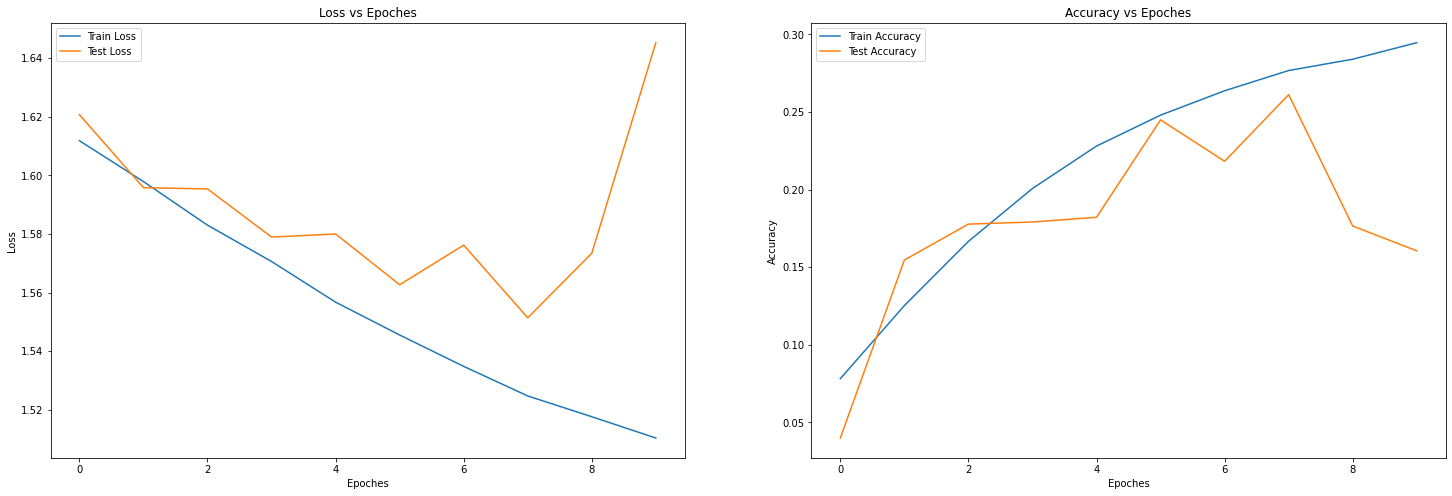

In [ ]:
plotplot(train_losses, test_losses, train_acces, test_acces)
# train_losses